In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

'''
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass
    
'''

'\nif torch.cuda.is_available():\n  torch.set_default_tensor_type(torch.cuda.FloatTensor)\n  print("using cuda:", torch.cuda.get_device_name(0))\n  pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n\nfrom multiprocessing import set_start_method\ntry:\n    set_start_method(\'spawn\')\nexcept RuntimeError:\n    pass\n    \n'

In [3]:
#torch.multiprocessing.set_start_method('spawn')


In [4]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        
        return sample, label

In [5]:
data = pandas.read_csv('dataset/qm9.csv')
data.head(5)


,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
0,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246


In [6]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data[["smiles","Molecule"]].head(1)
len(data)

133885

In [7]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(data.Molecule.values, )

In [8]:
y = data.alpha.values.reshape((-1,1))
X = data.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

len(X_train)

114471

In [9]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
X_validation_t.shape

cuda:0


torch.Size([6025, 35, 24])

In [11]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
         
        length = dims[0]
        number_tokens = dims[1]
         
     
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [12]:
#epochs = 500
epochs = 1

dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [13]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
#model.to(device)
model.cuda()

Net(
  (lstm): LSTM(24, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[0.0114]]], device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)
len(train_loader)

895

In [17]:
i = 0
for smiles, labels in train_loader:
    print("i", i)
    i += 1
    break

i 0


In [21]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    print("epochs", e+1)
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors 
        smiles = torch.tensor(smiles, device=device).float()
        labels = torch.tensor(labels, device=device).float()

        print('smiles.shape', smiles.shape, 'labels.shape', labels.shape)        
        
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass
         
        output = model(smiles) #Forward pass of the mini-batch
        print("output.shape", output.shape)        
        
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
         
         
        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()
         
        lr_scheduler.step(validation_loss)
         
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%10 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))

epochs 1
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])


/home/tony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/tony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.sha

output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.shape torch.Size([128, 35, 24]) labels.shape torch.Size([128, 1])
output.shape torch.Size([1, 128, 1])
smiles.sha

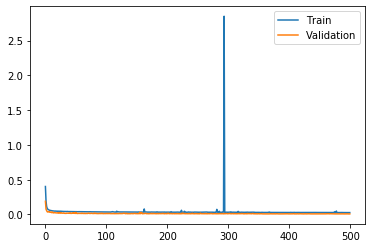

In [19]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [20]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)

In [21]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.008139243349432945

In [22]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()

In [23]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.007	Test RMSE: 0.007


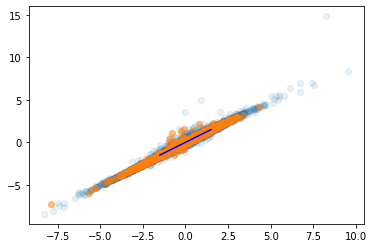

In [24]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

In [25]:
y_pred_test = model(X_test_t)

for i in range(10):
    print(y_pred_test[0,i,:])
    
print(y_pred_test.shape)

tensor([-2.3043], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0.3711], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0.1732], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0.4740], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0.2920], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.0305], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0.5113], device='cuda:0', grad_fn=<SliceBackward>)
tensor([1.3382], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.8772], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.9785], device='cuda:0', grad_fn=<SliceBackward>)
torch.Size([1, 13389, 1])


In [28]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y_%m_%d_%H_%M")
G_filename = 'pre_train_model/GAN10_' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(model, open(G_filename, 'wb'))

G_model = pickle.load(open(G_filename, 'rb'))

save model to file: pre_train_model/GAN10_2021_04_10_16_49.sav
